Homework 1 - Implementation
=====================
student names: Guy Levy, Doron Ben Shushan<br>
student i.ds: 206865362, xxxxxxxxx

<b> setup

In [43]:
# get image
# turn image into array
from PIL import Image
import numpy as np
import math
from math import inf, ceil, floor
import matplotlib.pyplot as plt
 
img = Image.open('Lenna.png')
np_img = np.asarray(img)

print(np_img.shape)

(512, 512, 3)


In [44]:
# turn image array to gray scale
np_img_gs = np.mean(np_img, axis = 2, dtype = np.int64)
print(np_img_gs.shape) 
print(np_img_gs)
print("max value:",np_img_gs.max())
print("min value:",np_img_gs.min())

(512, 512)
[[162 162 164 ... 166 153 129]
 [162 162 164 ... 166 153 129]
 [162 162 164 ... 166 153 129]
 ...
 [ 54  54  59 ... 110 105 106]
 [ 53  53  63 ... 109 111 113]
 [ 53  53  63 ... 109 111 113]]
max value: 240
min value: 35


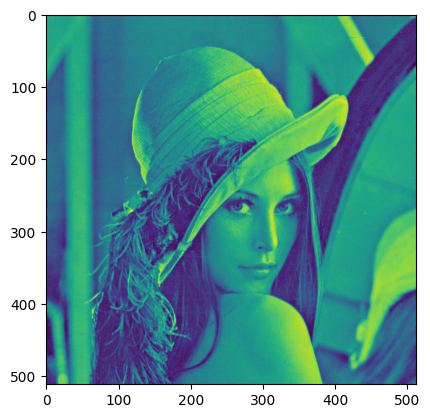

In [45]:
plt.imshow(np_img_gs)

<b> question 1

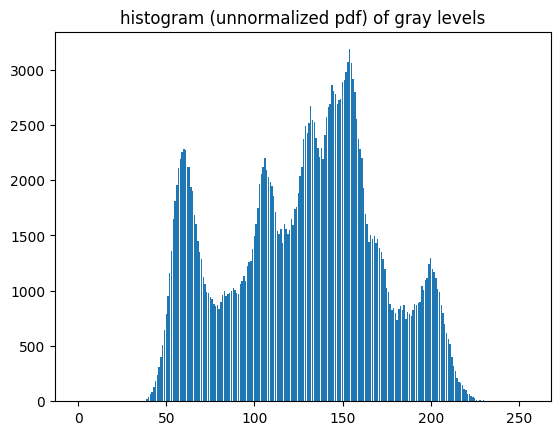

In [46]:
# estimate pdf of gray levels with histogram
hist = {value:0 for value in range(256)}
for value in np_img_gs.flatten():
    hist[value] += 1
plt.title("histogram (unnormalized pdf) of gray levels", fontdict=None, loc='center')
plt.bar(list(hist.keys()), hist.values())
plt.show()

<b> question 2

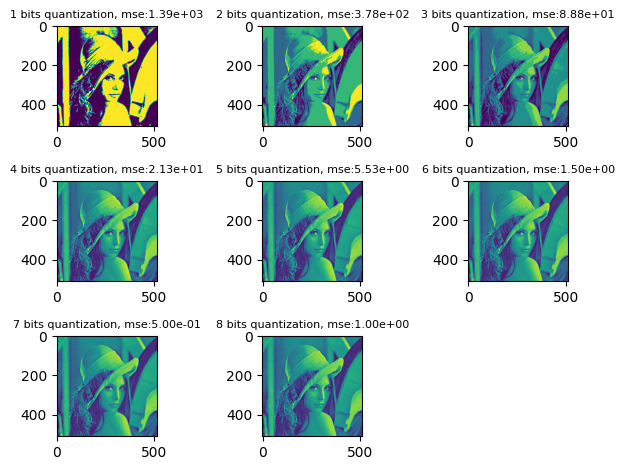

In [47]:
img = np_img_gs
rows, cols = 3, 3
MSEs = []
Decisions = []
Representations = []

for b in range(1, 9):
    plt.subplot(rows, cols, b)
    b_img = img
    
    Ds, Rs = [0], []
    for i in range(2**b):
        d_begin = int(256 * (i / 2**b))
        d_end   = int(256 * ((i + 1) / 2**b))
        r = int((d_end + d_begin)/2)
        b_img = np.where((b_img >= d_begin) & (b_img <= d_end),r , b_img)
        Ds.append(d_end)
        Rs.append(r)
        
    mse = ((b_img - img)**2).mean()
    MSEs.append(mse)
    Decisions.append(Ds)
    Representations.append(Rs)
    
    plt.title(f"{b} bits quantization, mse:{mse:.2e}", fontdict=None, loc='center', fontsize = 8)
    plt.imshow(b_img)

plt.tight_layout()
plt.show()

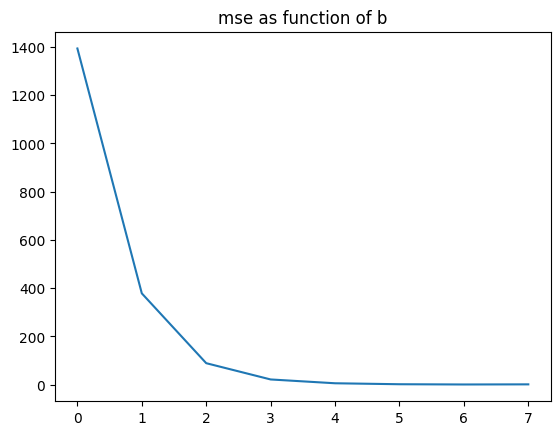

In [48]:
plt.title("mse as function of b", fontdict=None, loc='center')
plt.plot(MSEs)
plt.show() # (2a) ploting mse as a function of b

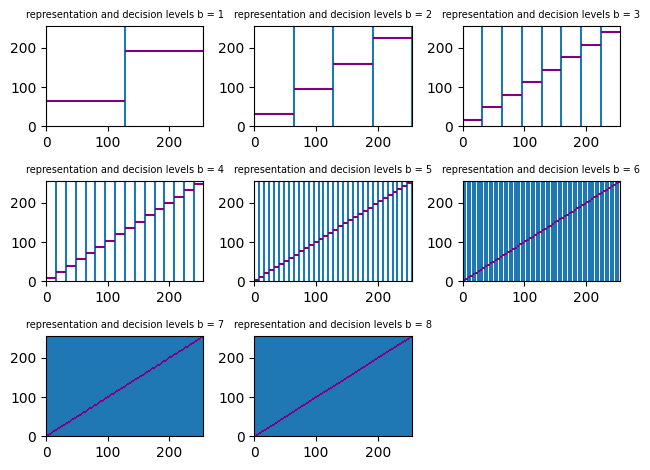

In [49]:
for b in range(1, 9):
    plt.subplot(rows, cols, b)
    b_img = img

    plt.title(f"representation and decision levels b = {b}", fontdict=None, loc='center', fontsize = 7)
    plt.vlines(x = Decisions[b-1], ymin = 0, ymax = 255)
    plt.hlines(y= Representations[b-1], xmin = Decisions[b-1][:-1], xmax= Decisions[b-1][1:], colors='purple')
    plt.xlim(0,255)
    plt.ylim(0,255)
    
plt.tight_layout()
plt.show() # (2b) plotting represantation and decisions levels for each b 

<b> utilities

In [50]:
def show_quantized_image(img,Ds,Rs):
    b_img = img
    for i in range(len(Rs)):
        b_img = np.where((b_img >= Ds[i]) & (b_img <= Ds[i+1]), Rs[i] , b_img)
    plt.imshow(b_img)
    plt.show()
    
def show_levels(Ds,Rs,bits):
    plt.vlines(x = Ds, ymin = 0, ymax = 255)
    plt.hlines(y= Rs, xmin = Ds[:-1], xmax= Ds[1:], colors='purple')
    plt.xlim(0,255)
    plt.ylim(0,255)

def calc_mse(img,Ds,Rs):
    """
       0  [d0  d1  d2  d3  d4  d5  d6]  255
        [r0  r1  r2  r3  r4  r5  r6  d7]
    """
    b_img = img
    for i in range(len(Rs)):
        r       = int(Rs[i])
        d_begin = floor(Ds[i])
        d_end   = ceil(Ds[i+1])
        b_img   = np.where((b_img >= d_begin) & (b_img < d_end),r , b_img)
    return ((b_img - img)**2).mean()

<b> question 3 - implementing Max-Lloyd

In [63]:
def Max_Lloyd(img, pdf, initial_decisions, eps, bits):
    
    Ds = np.array([0] + initial_decisions + [256], dtype = np.float32)     #   0  [d0  d1  d2  d3  d4  d5  d6]  255
    Rs = np.zeros(len(initial_decisions) + 1, dtype = np.float32)          #    [r0  r1  r2  r3  r4  r5  r6  d7]
    pdf = np.array(pdf) + 1 # +1 for evoiding dividing by 0
    
    mse_prev = inf
    mse = calc_mse(img, Ds, Rs)
    
    while  mse_prev - mse > eps:

        for i in range(len(Ds)-1):
            Xs = np.array(list(range(int(Ds[i]),int(Ds[i+1]))))
            Rs[i] = (pdf[Xs] * Xs).sum() / pdf[Xs].sum()

        for j in range(1,len(Ds)-1):
            Ds[j] = float(Rs[j-1] + Rs[j]) / 2.0
            
        mse_prev = mse
        mse = calc_mse(img, Ds, Rs)
        
    Decisions = [int(f) for f in Ds.tolist()[1:-1]] # not including 0, 255
    Representations = [int(f) for f in Rs.tolist()]
    
    return (Decisions, Representations, mse)

<b> question 4 - a. MSE as a function of bit budget

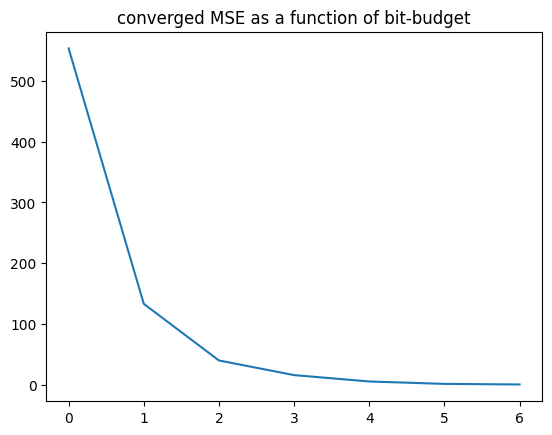

In [64]:
img = np_img_gs
pdf = list(hist.values())

MSEs = []
for b in range(1,8):
    initial_decisions = Decisions[b-1][1:-1] # uniform quantization from question 2
    D,R,mse = Max_Lloyd(img, pdf, initial_decisions, eps = 0.1, bits = b)
    MSEs.append(mse)
    

plt.title("converged MSE as a function of bit-budget", fontdict=None, loc='center')
plt.plot(MSEs)
plt.show()


<b> 4 - b. plotting decision and represantation levels for each b

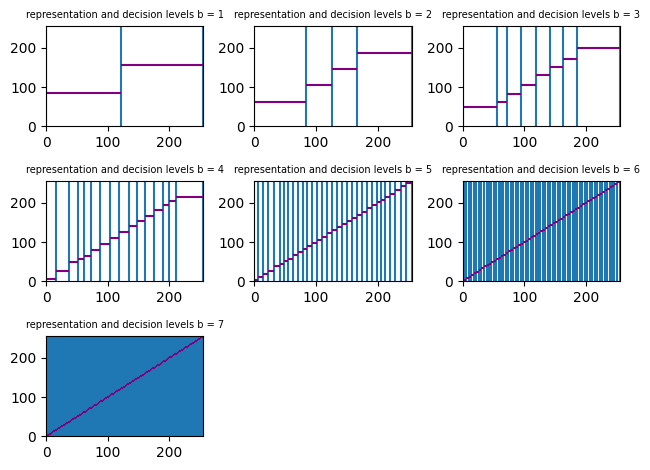

In [65]:
img = np_img_gs
pdf = list(hist.values())


for b in range(1,8):
    plt.subplot(rows, cols, b)
    plt.title(f"representation and decision levels b = {b}", fontdict=None, loc='center', fontsize = 7)
    initial_decisions = Decisions[b-1][1:-1] # uniform quantization from question 2
    D,R,mse = Max_Lloyd(img, pdf, initial_decisions, eps = 0.1, bits = b)
    show_levels([0] + D + [255],R,b)
    
plt.tight_layout()
plt.show()

<b> 4.c: <br> </b>
As we expected, the optimized quantization is not uniform.<br>
Particularly we can see that for pixel value ranges that occurr less we get less representation values.<br>
Though as we increase the bit-budget those differences diminish and the quantization we get after optimizing is very close to uniform.<br>